# Face recognition

Plan:
- prepare dataset:
    - dataframe with all faces
    - dataset with random training transformations
    - batched dataloaders
    
    
- create model for embeddings extraction
    - choose backbone (preferably fast and lightweight)
    - dropout regularization
    - add FC layer with embedding size
    - add BN to center embeddings
    
- create trainable loss function
    - simple softmax
        - FC layer (trainable)
        - CELoss
    - Arcface
        - class centroids in embedding space (trainable)
        - cos(theta+m) for true class, cos(thata) for other classes
        - scale by s
        - CELoss
        
- train models
    - single epoch fuction
    - full train function
    - optimizer for model + trainable loss training
    - plot loss and metric curves

- plot cosinus similarity distributions (separately for seen and unseen faces)
    - same faces
    - different faces
    
- calculate custom metric TPR@FPR
- analyze embedding vectors L2 norm (quality of photo?)

Set full train mode or fast mode.

In [1]:
full_train = True

Usual imports.

In [2]:
%matplotlib inline
import warnings
import tqdm
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import timm
import time
import sys
import shutil
import requests
import random
import psutil
import pandas as pd
import os
import numpy as np
import mmcv
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import json
import imghdr
import gc
import cvzone
import cv2
import copy
import albumentations as A
from tqdm.notebook import tqdm
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import colors
from IPython.display import clear_output
from albumentations.pytorch import ToTensorV2

torch.multiprocessing.set_sharing_strategy('file_system')

mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'

warnings.filterwarnings('ignore')

Paths.

In [3]:
# original dataset path
ds_path = '/home/sergey/DATASETS_ML/celebA_full/'

# recognition model data
recognition_path = os.getcwd() + '/models/recognition/'
# config file: normalization parameters and stuff
cfg_recognition_path = recognition_path+'best_model_cfg.txt'
# image size file path
custom_params_recognition_path = recognition_path+'custom_params.txt'
# temp weights during training
temp_model_weights = recognition_path+'tmp_recog_model_weights.pt'

# best models: pure CE and Arcface
best_model_ce_path = recognition_path+'best_recog_model.pt'
best_model_arc_path = recognition_path+'best_recog_model_arc.pt'

# tabular data
table_path = os.getcwd() + '/tables/'
# facial landmarks - full
landmark_path_full = table_path + '/final_landmarks.pkl'
# facial landmarks - small (filtered)
landmark_path = table_path + '/final_landmarks_small.pkl'
# custom train-test split
train_test_split_path = table_path + '/train_test_split.csv'
# embeddings: pure CE and Arcface
embed_ce_path = table_path + '/embed_ce.npy'
embed_arc_path = table_path + '/embed_arc.npy'

Fix random.

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

random_seed = 2077
seed_everything(random_seed)

Set multiple workers for dataloaders.

In [5]:
if 'nt' not in os.name:
    num_workers = 8
else:
    num_workers = 1
print('num_workers =', num_workers)

pin_memory=True

num_workers = 8


Useful function.

In [6]:
def clear_GPU():
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

Set GPU.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Hyperparameters!

In [8]:
drop_rate = 0.5
embed_size = 512
im_width_over_height = 0.7

In [9]:
# cropped faces will be resized to this dimentions
image_height_k = 1.
im_height = int(224*image_height_k) if full_train else 100

# images are filtered by size
# large value -> less images to train on
quantile_image_size = 0.09 if full_train else 0.3

# filter out images facing sideways or up/down
# large value -> less images to train on
quantile_wrong_facing = 0.14 if full_train else 0.4

epoch_softmax = 8 if full_train else 3
epoch_arcface = 16 if full_train else 3

predict_number_reduction = (1-quantile_image_size)
predict_number_reduction *= (1-quantile_wrong_facing)**2
print('the dataset will be reduced to about', predict_number_reduction, 'of its size')

the dataset will be reduced to about 0.673036 of its size


In [10]:
# calculate embeddings as a mean of original and flipped image on inference
mean_flipped=True

# use label smoothing
label_smoothing_softmax = 0.15
label_smoothing_arcface = 0.1

# training parameters
weight_decay = 1e-3

# scheduler type
# sched_type = None
# sched_type = 'exp'
sched_type = 'plateau'

# if exp: LR will be reduced to this k at the end of training
lr_decay_max_epoch = 1/3
lr_decay_max_epoch_arc = 1/6

# if plateau:
lr_decay_on_plateau = 0.1

# clip gradients
max_weight_grad_model = 10
max_weight_grad_loss = 10

# face location noise
space_noise = im_height // 80

im_width = int(im_height * im_width_over_height)

face_transform_kwargs = dict(
    desiredEyesY=0.45,
    vertical_face_scale=4.75
)

opt_alg = optim.AdamW

Model selection.

In [11]:
# batch size sadly depends on selected model
batch_size = 64 if full_train else 128

# super fast
# bb_name = 'semnasnet_075'

# fast:
# bb_name = 'semnasnet_100'

# balance
# bb_name = 'rexnet_130'

# good:
# bb_name = 'rexnet_200'

# also good
# bb_name = 'efficientnetv2_rw_t'

# even better:
bb_name = 'efficientnetv2_rw_s'

if not full_train: bb_name = 'semnasnet_075'

Save some parameters to separate file for future inference.

In [12]:
custom_params = dict(
    im_height=im_height,
    im_width=im_width,
    drop_rate=drop_rate,
    embed_size=embed_size
)

custom_params.update(face_transform_kwargs)

json.dump(custom_params, open(custom_params_recognition_path,'w'))

## Load and preprocess files list

Load all files and check bbox sizes lower percentiles. Set minimal image size for future work.

(121.66226722717282, 88.05443092346194)

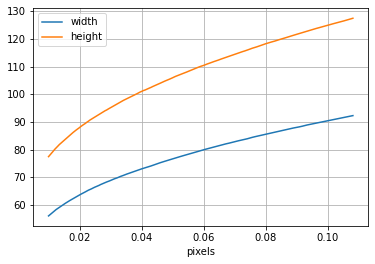

In [13]:
df_final = pd.read_pickle(landmark_path_full)

x = np.linspace(0.01, quantile_image_size*1.2, 200)
plt.plot(x, [df_final['w'].quantile(i) for i in x], label='width')
plt.plot(x, [df_final['h'].quantile(i) for i in x], label='height')
plt.grid()
plt.xlabel('quantile')
plt.xlabel('pixels')
plt.legend()

min_im_height = df_final['h'].quantile(quantile_image_size)
min_im_width = df_final['w'].quantile(quantile_image_size)

min_im_height, min_im_width

Now lets choose data rows for the training:
- bbox size should be >= limit
- number of images for each person should be >= limit

In [14]:
# read file
df_final = pd.read_pickle(landmark_path_full)
print('Total images with landmarks ', len(df_final))

# drop small bboxes
df_final = df_final[df_final['w'] >= min_im_width]
df_final = df_final[df_final['h'] >= min_im_height]
print('Total images after filtering', len(df_final))

# count images per person
df_final['count'] = df_final.groupby('person')['file'].transform('count')# save dataframe
df_final.to_pickle(landmark_path)

Total images with landmarks  190375
Total images after filtering 172983


Now lets filter out 'bad' images:
- facing sideways
- facing up or down

For this lets calculate two numbers for each image:
- distance between eyes.mean() and (nose+mouth).mean() / distance between eyes
- max distance between eye and nose / sqrt(sqr(min distance between eye and nose) + sqt(eye to eye distance))

In [15]:
def get_landmark_distances(coordinates, nose_weight=4):
    res = {}
    left_eye = coordinates[0]
    right_eye = coordinates[1]
    nose = coordinates[2]
    
    top_center = (left_eye + right_eye) / 2
    
    bottom_center = nose * nose_weight 
    bottom_center += coordinates[3] + coordinates[4]
    bottom_center /= (2 + nose_weight)
    
    res['eye_to_eye'] = np.linalg.norm(left_eye - right_eye)
    res['bottom_to_top'] = np.linalg.norm(bottom_center - top_center) 
    res['bottom_to_top'] /= res['eye_to_eye']
    
    left_eye_to_nose = np.linalg.norm(left_eye - nose)
    right_eye_to_nose = np.linalg.norm(right_eye - nose)    
    max_dist_eye_to_nose = max(left_eye_to_nose, right_eye_to_nose) 
    max_dist_eye_to_nose /= res['eye_to_eye']
    min_dist_eye_to_nose = min(left_eye_to_nose, right_eye_to_nose) 
    min_dist_eye_to_nose /= res['eye_to_eye']
    
    allowed_dist_eye_to_nose = (res['eye_to_eye']**2 +
                                       min_dist_eye_to_nose**2
                                      )**0.5
    allowed_dist_eye_to_nose /= res['eye_to_eye']
    
    res['eye_to_nose_k'] = max_dist_eye_to_nose / allowed_dist_eye_to_nose
    
    return res

In [16]:
tmp = df_final['lm_abs'].apply(lambda x: get_landmark_distances(x))
tmp = pd.DataFrame(list(tmp.values))
tmp.index = df_final.index
df_final = df_final.join(tmp)

bottom_to_top  eye_to_nose_k
count  172983.000000  172983.000000
mean        0.789704       0.894498
std         0.097186       0.121432
min         0.180099       0.507943
10%         0.687135       0.767411
20%         0.721781       0.805306
30%         0.744787       0.830622
40%         0.764222       0.852996
50%         0.782560       0.875463
60%         0.801733       0.900938
70%         0.823820       0.932852
80%         0.852667       0.976003
90%         0.898444       1.045513
max         3.864193       3.862985

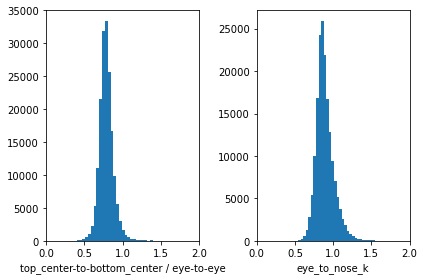

In [17]:
fig = plt.figure()
bins=100

plt.subplot(1,2,1)
plt.hist(df_final['bottom_to_top'], bins=bins)
plt.xlim([0, 2])
plt.xlabel('top_center-to-bottom_center / eye-to-eye')

plt.subplot(1,2,2)
plt.hist(df_final['eye_to_nose_k'], bins=bins)
plt.xlim([0, 2])
plt.xlabel('eye_to_nose_k')

fig.patch.set_facecolor('xkcd:white')
fig.tight_layout()

df_final[['bottom_to_top', 'eye_to_nose_k']].describe(percentiles=np.arange(0.1,1,0.1))

Both distributions look almost normal. Now we have to set cut limits.

- bottom_to_top must be larger than some value, otherwise a face is facing up/down
- eye_to_nose_k must be lower than some value, otherwise a face is facing sideways

The simplest way to set these limits - get some quantiles.

In [18]:
bottom_to_top_lim = df_final['bottom_to_top'].quantile(quantile_wrong_facing)
eye_to_nose_k_lim = df_final['eye_to_nose_k'].quantile(1 - quantile_wrong_facing)

And now filter

In [19]:
print(len(df_final))
df_final = df_final[df_final['bottom_to_top'] > bottom_to_top_lim]
print(len(df_final))
df_final = df_final[df_final['eye_to_nose_k'] < eye_to_nose_k_lim]
print(len(df_final))

172983
148765
124575


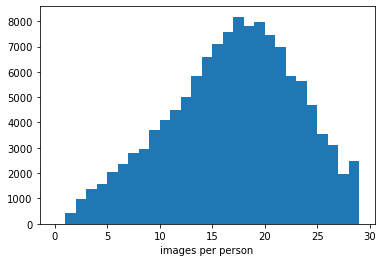

In [20]:
df_final['count'] = df_final.groupby('person')['file'].transform('count')
plt.hist(df_final['count'], bins = np.arange(0,30))
plt.xlabel('images per person');

Now lets save this dataframe. We will use it for training, metric calculation and for inference (finding similar people).

In [21]:
df_final.to_pickle(landmark_path)

As we can see there are some people who have only 1-2 pictures. Lets set some cutoff value count_limit and split our 'good' images:
- if images count per person < count_limit - use for metric calculation
- otherwise - use for training or validation

In [22]:
count_limit = max(int(df_final['count'].quantile(0.05)), 3)
count_limit

5

In [23]:
# drop small images counts
print('Total good images: ', len(df_final))
df_final = df_final[df_final['count'] >= count_limit]

# we dropped some persons so we need to re-encode 'person' column
le = preprocessing.LabelEncoder()
df_final['person'] = le.fit_transform(df_final['person'])

# Warning! Here we reset index! It will be important
df_final = df_final.reset_index()

print(
    'Used images for training and val', 
    len(df_final), 
    '\nNumber of used persons', 
    len(df_final['person'].unique()), 
    '\nCount limit', count_limit
)

num_classes = len(df_final['person'].unique())

Total good images:  124575
Used images for training and val 120204 
Number of used persons 8248 
Count limit 5


DF head:

In [24]:
df_final.head()

image_id                                               file  \
0  000002.jpg  /home/sergey/DATASETS_ML/celebA_full/img_celeb...   
1  000006.jpg  /home/sergey/DATASETS_ML/celebA_full/img_celeb...   
2  000007.jpg  /home/sergey/DATASETS_ML/celebA_full/img_celeb...   
3  000008.jpg  /home/sergey/DATASETS_ML/celebA_full/img_celeb...   
4  000009.jpg  /home/sergey/DATASETS_ML/celebA_full/img_celeb...   

                                              lm_abs  person  part  \
0  [[141.08926, 206.28888], [220.20297, 205.88448...    2469     0   
1  [[202.8391, 159.11615], [261.73428, 166.19376]...    3440     0   
2  [[130.63033, 199.46684], [204.41138, 188.9676]...    7406     0   
3  [[278.6568, 198.25537], [344.96848, 205.06714]...    5235     0   
4  [[709.5045, 448.08984], [843.4549, 444.1219], ...    2794     0   

            w           h  count  eye_to_eye  bottom_to_top  eye_to_nose_k  
0  221.184631  306.078148     19   79.114746       0.785746       0.967904  
1  181.359772  250.769264     18   59.318932       0.783223       0.856932  
2  214.455200  295.185349     28   74.524338       0.801566       0.897175  
3  211.907898  294.581764     24   66.660622       0.923935       0.991255  
4  352.598083  483.237579     21  134.009125       0.795279       0.944194

Classes are not balanced. Lets add sqrt balancing.

In [25]:
df_final.groupby('person')['w'].count()

person
0       18
1       17
2       17
3       10
4       12
        ..
8243    12
8244    20
8245    20
8246    20
8247     7
Name: w, Length: 8248, dtype: int64

In [26]:
class_balance = df_final.groupby('person')['w'].count()
class_balance = class_balance.values
class_balance = np.sqrt(1 / class_balance)
class_balance /= class_balance.mean()
class_balance = torch.tensor(class_balance).float()
class_balance

tensor([0.8359, 0.8601, 0.8601,  ..., 0.7930, 0.7930, 1.3404])

# Create dataset and augmentations

Dataset class is used to load and augment images.

At first there was a huge problem with glasses and sunglasses - the model put them in embeddings!

So we just draw some random glasses over some faces during training.

  0%|          | 0/6 [00:00<?, ?it/s]

http://clipart-library.com/img1/1464176.png


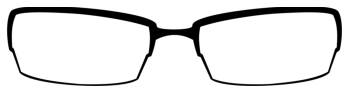

http://clipart-library.com/images_k/glasses-png-transparent/glasses-png-transparent-1.png


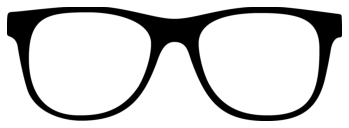

http://clipart-library.com/images_k/glasses-png-transparent/glasses-png-transparent-10.png


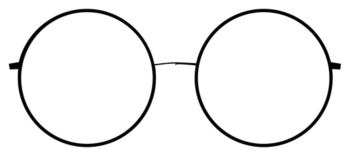

http://clipart-library.com/images_k/glasses-png-transparent/glasses-png-transparent-22.png


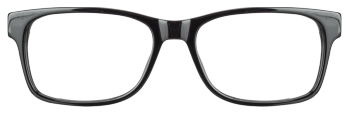

http://clipart-library.com/image_gallery2/Sunglasses.png


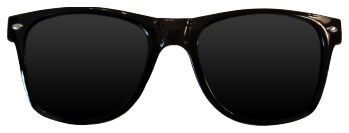

http://clipart-library.com/image_gallery2/Sunglasses-Free-Download-PNG.png


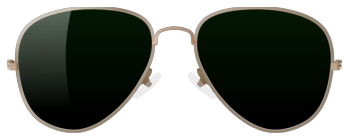

In [27]:
glasses_list = [
    'http://clipart-library.com/img1/1464176.png',
    'http://clipart-library.com/images_k/glasses-png-transparent/glasses-png-transparent-1.png',
    'http://clipart-library.com/images_k/glasses-png-transparent/glasses-png-transparent-10.png',
    'http://clipart-library.com/images_k/glasses-png-transparent/glasses-png-transparent-22.png',
    'http://clipart-library.com/image_gallery2/Sunglasses.png',
    'http://clipart-library.com/image_gallery2/Sunglasses-Free-Download-PNG.png'
]

for i, url in enumerate(tqdm(glasses_list)):
    a = Image.open(requests.get(url, stream=True).raw)
    a = np.array(a)
    # here we crop empty white borders of images
    b = a[:,:,-1]
    a = a[~np.all(b == 0, axis=1)]
    a = np.swapaxes(a, 0, 1)
    b = a[:,:,-1]
    a = a[~np.all(b == 0, axis=1)]
    a = np.swapaxes(a, 0, 1)
    glasses_list[i] = a
    print(url)
    plt.imshow(a)
    plt.axis('off')
    plt.show()

Dataset class.

In [28]:
class CroppedDataset(Dataset):
    def __init__(self, 
                 df_in, 
                 im_size=(224,224), 
                 stats=((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
                 transform=None,
                 desiredEyesY=0.45,
                 vertical_face_scale=5.5,
                 glass_prob=0.33,
                 k_glasses_width=0.74
                ):
        
        self.df = df_in
        self.im_size = im_size
        self.stats = stats
        self.desiredEyesY = desiredEyesY
        self.vertical_face_scale = vertical_face_scale
        self.transform = transform
        
        # basic transform to prepare image for CNN
        self.basic_transform = A.Compose([
                # A.Resize(*self.im_size),
                A.CenterCrop(self.im_size[1], self.im_size[0]),
                A.Normalize(*self.stats),
                ToTensorV2(),
            ])
        
        self.k_glasses_width = k_glasses_width
        self.k_glasses_eyes_y = desiredEyesY + 0.02
        self.glass_prob = glass_prob
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row['file']
        image = cv2.imread(fname)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # face landmarks coordinates
        coordinates = row['lm_abs']
        
        # here is the magic - face is aligned by landmarks
        image = self.align(image, coordinates)
        
        
        if self.transform is not None and np.random.rand() <= self.glass_prob:
            glass = np.random.choice(glasses_list)
            k = self.k_glasses_width
            k = min(1, random.uniform(k*0.9, k*1.1))
            w = image.shape[1] * k
            h = w * glass.shape[0] / glass.shape[1]
            h = random.uniform(h*0.9, h*1.1)
            h = int(h)
            w = int(w)
            
            glass = cv2.resize(glass, (w,h))
            # glass = cvzone.rotateImage(glass, np.random.rand()*3)
            
            kx = 0.03
            ky = 0.06
            x = image.shape[1] / 2 - w / 2
            x = random.uniform(x*(1-kx), x*(1+kx))
            x = int(x)
            y = image.shape[0] * self.k_glasses_eyes_y - h / 2
            y = random.uniform(y*(1-ky), y*(1+ky))
            y = int(y)
            
            image = cvzone.overlayPNG(image, glass, [x,y])
        
        # custom transform for training. Result - image
        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        # basic transform. Result - tenson
        image = self.basic_transform(image=image)['image']
        
        return image, row['person']

    def denorm(self, img_tensors):
        '''
        convert normalized image array/tensor to usual plottable image
        '''
        img_tensors = img_tensors * self.stats[1][0] + self.stats[0][0]
        if type(img_tensors) == torch.Tensor:
            img = img_tensors.cpu().permute(1,2,0).numpy()
        elif type(img_tensors) == np.ndarray:
            img = np.transpose(img_tensors, (1,2,0))
        img = np.clip(img, 0, 1)
        return img
    
    def imshow(self, img_tensor):
        '''
        simply show a single image from tensor
        '''
        img = self.denorm(img_tensor)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    def align(self, image, coordinates, nose_weight=4):
        
        """
        Aligns image so that eyes are on a single horizontal line
        and scalse image by eye-to-eye distance OR by eyes_center-to-weighted_mouth+nose_center
        """

        leftEyeCenter = coordinates[0]
        rightEyeCenter = coordinates[1]
        
        # we will scale face by two sizes: 
        # eye-to-eye
        # eyes_center-to-weighted_lower_face_center
        mouth_weight = 1
        sum_weingt = 2 + nose_weight

        bottom_center = coordinates[2] * nose_weight + (coordinates[3] + coordinates[4])
        bottom_center = bottom_center / sum_weingt

        top_center = (leftEyeCenter + rightEyeCenter) / 2

        # compute the angle between the eye centroids
        d_eyes = rightEyeCenter - leftEyeCenter
        angle = np.degrees(np.arctan2(*d_eyes[::-1]))

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        # desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        top_bottom_dist = (np.abs(
            np.linalg.norm(np.cross(rightEyeCenter-leftEyeCenter, leftEyeCenter-bottom_center))
        )/np.linalg.norm(rightEyeCenter-leftEyeCenter))

        eyes_dist = np.linalg.norm(d_eyes)

        scale1 = self.im_size[1] / (top_bottom_dist * self.vertical_face_scale)
        scale2 = self.im_size[1] / (eyes_dist * self.vertical_face_scale / 1.29)

        # scale image to get same distance between eyes OR between top and bottom "face centers"
        scale = min(scale1, scale2)

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(top_center, angle, scale)

        # update the translation component of the matrix
        tX = self.im_size[0] * 0.5
        tY = self.im_size[1] * self.desiredEyesY
        M[0, 2] += (tX - top_center[0])
        M[1, 2] += (tY - top_center[1])

        # apply the affine transformation
        output = cv2.warpAffine(src=image, 
                                M=M, 
                                dsize=(self.im_size[0]+2*space_noise, self.im_size[1]+2*space_noise),
                                flags=cv2.INTER_CUBIC)

        return output    

Some aggressive training augmentations.

In [29]:
color_shift = 5 # default 20
gamma_limit = (30,60)
cutout_size = min(im_height, im_width) // 3
cutout_prob = 0.12

train_transform = A.Compose([
    # A.RGBShift(r_shift_limit=color_shift, 
    #            g_shift_limit=color_shift, 
    #            b_shift_limit=color_shift),
    A.HueSaturationValue(),
    A.RandomBrightnessContrast(),
    A.RandomGamma(),
    A.RandomToneCurve(),
    A.Posterize(p=0.05),
    
    A.ElasticTransform(alpha_affine=1),
    A.OpticalDistortion(shift_limit=0),
    
    A.OneOf([
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
        A.GaussianBlur(blur_limit=(1, 3), p=0.3),
        A.MotionBlur(blur_limit=(3,4), p=0.3),
    ], p=0.5),

    # A.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_upper=1, shadow_dimension=3, p=0.1),
    # A.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_upper=1, shadow_dimension=3, p=0.1),
    # A.PixelDropout(dropout_prob=0.02, p=0.2),
    
    A.Cutout(num_holes=1, max_h_size=cutout_size, max_w_size=cutout_size, p=cutout_prob),
    A.Cutout(num_holes=1, max_h_size=cutout_size, max_w_size=cutout_size, p=cutout_prob),
    A.Cutout(num_holes=1, max_h_size=cutout_size, max_w_size=cutout_size, p=cutout_prob),
    
    A.HorizontalFlip(),
    A.RandomCrop(im_height, im_width),
    A.GaussNoise(var_limit=(30, 200))
])

Create temp dataloader.

In [30]:
ds = CroppedDataset(df_final, 
                    im_size=(im_width, im_height), 
                    transform=train_transform, 
                    **face_transform_kwargs)
dl = DataLoader(ds, batch_size=25, num_workers=num_workers, shuffle=True)

Check if dataset is working OK.

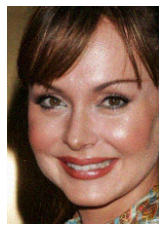

In [31]:
ds.imshow(ds[4][0])

Check dataloader with augmentations.

torch.Size([25, 3, 224, 156])


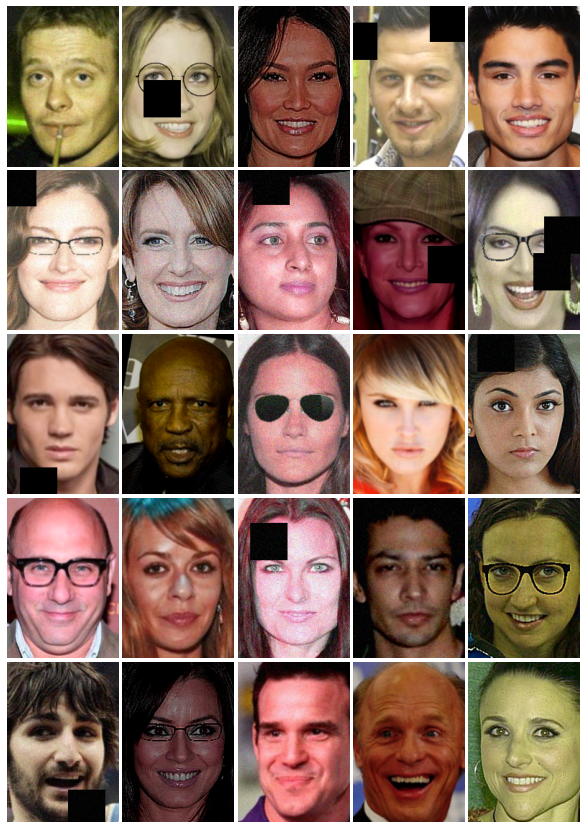

In [32]:
w = 12
fig = plt.figure(figsize=(w, 5/4*w))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),
                 axes_pad=0.05,
                 )

for i, p in dl:
    print(i.shape)
    for im in zip(i,grid):
        im[1].imshow(ds.denorm(im[0]))
        im[1].axis('off')
    break

# Model

We'll use pretrained models from TIMM lib.

Here are some fast and cool models.

In [33]:
timm.list_models('semn*', pretrained=True)

['semnasnet_075', 'semnasnet_100']

In [34]:
# timm.list_models('eff*net*', pretrained=True)
# timm.list_models('mobil*', pretrained=True)
timm.list_models('rexnet*', pretrained=True)

['rexnet_100', 'rexnet_130', 'rexnet_150', 'rexnet_200']

In [35]:
timm.list_models('effi*', pretrained=True)

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t']

Now we load the model and its config. Config is saved to file.

In [36]:
backbone = timm.create_model(bb_name, pretrained=True, num_classes=0)
backbone.eval();
print('backbone parameters:', sum(p.numel() for p in backbone.parameters() if p.requires_grad))

cfg = backbone.default_cfg

# save cfg for future use of trained network
json.dump(cfg, open(cfg_recognition_path,'w'))

# show config
cfg

backbone parameters: 22148296


{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_v2s_ra2_288-a6477665.pth',
 'num_classes': 1000,
 'input_size': (3, 288, 288),
 'pool_size': (9, 9),
 'crop_pct': 1.0,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier',
 'test_input_size': (3, 384, 384),
 'architecture': 'efficientnetv2_rw_s'}

Uncomment to see the model layers.

In [37]:
# backbone

And now - our custom model.

How does it work?

Image -> (backbone) -> 4-dim large embedding -> (embed head) -> 2-dim embeddings of preset size -> (optional: classifier) -> logits of training classes

In [38]:
class FaceRecognitionModel(nn.Module):
    def __init__(self, backbone, embed_size=512, drop_rate=0.33):
        '''
        backbone - CNN for reature extraction
        num_classes - number of predicted classes (persons)
        embed_size - embeddind dimentions
        '''
        super(FaceRecognitionModel, self).__init__()
        self.embed_size = embed_size
        self.backbone = backbone
        
        self.embed = nn.Sequential(
            nn.Flatten(), # now the head can work with any conv result
            nn.Dropout(drop_rate), # regularization
            nn.LazyLinear(embed_size, bias=False), # embed!
            nn.LazyBatchNorm1d(), # to center embeddings around 0
        )

    def forward(self, tensor):
        tensor = self.backbone(tensor)
        tensor = self.embed(tensor)
        return tensor # embeddings

Create model and test in on a single random batch.

In [39]:
model = FaceRecognitionModel(
    backbone, 
    embed_size=embed_size, 
    drop_rate=drop_rate
)
model.to(device)
a = torch.randn(4, 3, 180, 220, device=device)
with torch.no_grad():
    a = model(a)
print(a.shape)
del(a)

torch.Size([4, 512])


Count model parameters.

In [40]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

23066824

# Trainable loss

We want to train the model using cross-entropy loss for some set number of classes. This can be done by adding "classifier" head to the model. But we don't want the model to have these useless (in the future) parameters.

So we will use a trainable CE loss.

In [41]:
class TrainCELoss(nn.Module):
    def __init__(self, output_classes, kwargs_ce_loss={}):
        super().__init__()
        
        self.fc = nn.LazyLinear(output_classes, bias=False)
        self.ce_loss = nn.CrossEntropyLoss(**kwargs_ce_loss)
        
    def forward(self, embedding, target):
        logits = self.fc(embedding)
        preds = logits.argmax(dim=1)
        return self.ce_loss(logits, target), preds

# Train-val split

We already dropped some images - we'll use them for testing.

So now we'll split our dataframe into train and val samples.

In [42]:
test_size = max(0.15, len(df_final['person'].unique())/len(df_final))
test_size

0.15

In [43]:
_, val_idx = train_test_split(df_final.index, 
                                    test_size=test_size, 
                                    stratify=df_final['person'], 
                                    shuffle=True, random_state=random_seed)

New column to indicate.

In [44]:
df_final['part'] = 0
df_final['part'].loc[val_idx] = 1

And now - create dataloaders!

In [45]:
# datasets
cfg_stats = (cfg['mean'], cfg['std'])
kwargs = dict(im_size=(im_width, im_height), stats=cfg_stats)

ds_train = CroppedDataset(df_final[df_final['part']==0], 
                          **kwargs, 
                          transform=train_transform, 
                          **face_transform_kwargs)
ds_val = CroppedDataset(df_final[df_final['part']==1], 
                        **kwargs, 
                        **face_transform_kwargs)

# dataloaders
kwargs = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

dl_train = DataLoader(ds_train, **kwargs, shuffle=True)
dl_val = DataLoader(ds_val, **kwargs, shuffle=False)

# Train functions

In [46]:
def plot_train_curves(history, name='', best_min=True):
    '''
    plots loss, metric and LR curves
    '''
    train_loss, val_loss, train_metr, val_metr, lr = history['train_loss'], history['val_loss'], history['train_metr'], history['val_metr'], history['lr'], 
    fig = plt.figure(figsize=(6,8))
    fig.patch.set_facecolor('xkcd:white')
    
    plt.subplot(3,1,1)
    # all the stuff with quantiles is used to scale the plot around important part
    points = np.array(train_loss + val_loss, dtype=float)
    points = points[~np.isnan(points)]
    points = points[np.isfinite(points)]
    p = 0.08
    q1, q2 = np.nanquantile(points, p), np.nanquantile(points, 1-p)
    iqr = q2 - q1
    lim1 = max(np.nanmin(points) - iqr * 0.06, q1 - iqr * 1.2)
    lim2 = min(np.nanmax(points) + iqr * 0.06, q2 + iqr * 1.2)
    
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend()
    plt.ylim(lim1, lim2)
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.subplot(3,1,2)
    plt.plot(train_metr, label="train_metr")
    plt.plot(val_metr, label="val_metr")
    if best_min:
        my = np.array(val_metr).min()
        mx = np.argmin(np.array(val_metr))
    else:
        my = np.array(val_metr).max()
        mx = np.argmax(np.array(val_metr))
    # show the best metric with red circle
    plt.scatter(x=[mx], y=[my], c='red', s=80)
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("metric")

    plt.subplot(3,1,3)
    plt.plot(lr, label="LR")
    plt.xlabel("epochs")
    plt.ylabel("LR")
    plt.yscale('log')
    
    if len(name) > 0:
        plt.suptitle(name)
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.savefig(name+'.png')
    plt.show()

In [47]:
def single_epoch(model, optimizer, loss_fn, data_loader, 
                 metric, mode='val', batches_to_save=1):
    
    '''
    iterates through a dataloader and optionally trains model
    model - model to be trained or evaluated
    optimizer - optimizer for the model. For eval can be set to None
    loss_fn - loss function. Takes two tensors
    data_loader - image + keypoints dataloader
    metric - metric function. Takes two arrays
    mode - 'val' for evaluate or 'train' else for training
    batches_to_save - number of batches of images (np arrays) to save.
        Used during eval to show some pictures
    '''
    
    clear_GPU()
    
    torch.set_grad_enabled(mode == 'train')
    if mode == 'train':
        model.train()
    else:
        model.eval()
    
    pics = [] # images to save for plotting
    gts = [] # real labels
    preds = [] # predicted labels
    losses = [] # array for losses to keep track
    embeddings = []

    pbar = tqdm(data_loader)
    # for batch in tqdm(data_loader):
    for batch in pbar:
        
        # min_size = data_loader.batch_size // 2
        min_size = 6
        if batch[0].shape[0] < min_size and mode=='train':
            break
        
        X_batch = batch[0]
        Y_batch = batch[1]
        
        # save pictures
        if mode=='val' and len(pics) < batches_to_save:
            pics.append(X_batch.detach().numpy())
        
        # save real labels
        gts.append(Y_batch.detach().numpy())
        
        X_batch = X_batch.to(device, non_blocking=True)
        Y_batch = Y_batch.to(device, non_blocking=True)
        
        if mode == 'train': optimizer.zero_grad()

        # get and save embeddings
        embed = model(X_batch)
        if mode=='val' and mean_flipped:
            embed += model(X_batch.flip(3))
            embed = embed / 2
        embeddings.append(embed.cpu().detach().numpy())

        # loss
        loss, pred = loss_fn(embed, Y_batch.to(torch.long))
        # print(pred)
        labels = pred.cpu().detach().numpy()
        # print(labels)
        preds.append(labels)
        
        if mode == 'train':
            loss.backward()
            if max_weight_grad_model > 0:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), 
                    max_weight_grad_model)
                
            if max_weight_grad_loss > 0:
                torch.nn.utils.clip_grad_norm_(
                    loss_fn.parameters(), 
                    max_weight_grad_loss)
                
            optimizer.step()
            
        loss = loss.cpu().detach().item()
        losses.append(loss)
        
        pbar.set_description(f"loss = {loss:.2g}")

    # at the end if epoch all lists are turned to np arrays
    if mode=='val':
        pics = np.concatenate(pics, axis=0)
    
    gts = np.concatenate(gts, axis=0)
    embeddings = np.concatenate(embeddings, axis=0)
    preds = np.concatenate(preds, axis=0)

    epoch_loss = np.array(losses).mean()
    epoch_metr = metric(preds.flatten(), gts.flatten()).mean()
    
    torch.set_grad_enabled(True)
    model.eval()
    
    return dict(pics=pics, gts=gts, preds=preds, loss=epoch_loss, metr=epoch_metr, embeddings=embeddings)

In [48]:
def check_metrics(new_metr, old_metr, best_min_metr=False):
    """
    used to check if model is better than the current best and needs saving
    """
    if old_metr == False:
        return True
    
    if best_min_metr:
        return new_metr <= old_metr
    else:
        return new_metr >= old_metr

In [49]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val, 
          metric, best_min_metr=True, scheduler=None, 
          plots=True, set_best_params=True, 
          name='', zero_run_for_metrics=False):
    
    """
    runs:
    - one validation run to get the starting metrics
    - (epochs) runs of:
        - train
        - val
        - save metrics
        - if val vetrinc is better the previous best -> save model weights
        - plot training curves (if number of points is enough)
    - load best model weights
    """
    
    # calculate default metric and set it as "the best"
    if zero_run_for_metrics:
        val_res = single_epoch(model, optimizer, loss_fn, 
                               data_val, metric, mode='val')
        best_metr = val_res['metr']
        best_loss = val_res['loss']
        print(f'before training: val_loss: {best_loss:.2f}    val_metr: {best_metr:.2f}')
    else:
        best_metr = False
    best_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    # empty training history
    history = dict(
        train_loss = [],
        val_loss = [],
        train_metr = [],
        val_metr = [],
        lr = []
    )

    for epoch in range(epochs):
            
        print(f'Epoch {epoch+1}/{epochs}, best = {best_epoch}', end='    ')
        history['lr'].append(optimizer.param_groups[0]["lr"])
        
        # training
        train_res = single_epoch(model, optimizer, loss_fn, 
                                 data_tr, metric, mode='train')
        history['train_loss'].append(train_res['loss'])
        history['train_metr'].append(train_res['metr'])

        # validation
        val_res = single_epoch(model, optimizer, loss_fn, 
                               data_val, metric, mode='val')
        pics = val_res['pics']
        gts = val_res['gts']
        preds = val_res['preds']
        history['val_loss'].append(val_res['loss'])
        history['val_metr'].append(val_res['metr'])
        
        # print epoch result
        tr_loss = history['train_loss'][-1]
        tr_metr = history['train_metr'][-1]
        val_loss = history['val_loss'][-1]
        val_metr = history['val_metr'][-1]
        
        # we want to plot images after each epoch, so need to clear output
        if plots and epoch > 1:
            clear_output(wait=True)
        
        print(f'tr_loss: {tr_loss:.2f}  tr_metr: {tr_metr:.2f}' + \
              f'   val_loss: {val_loss:.2f}  val_metr: {val_metr:.2f}')
        
        if check_metrics(history['val_metr'][-1], best_metr, 
                         best_min_metr=best_min_metr):
            print('new best val metric!')
            best_epoch = epoch + 1
            best_metr = history['val_metr'][-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            try: os.remove(temp_model_weights)
            except: pass
            torch.save(model, temp_model_weights)

        # scheduler step (if needed)
        if scheduler != None:
            try:
                # scheduler.step(history['val_loss'][-1])
                scheduler.step(history['val_metr'][-1])
            except:
                scheduler.step()

        # visualize
        if plots:
            if epoch > 1:
                try:
                    plot_train_curves(history, name, best_min=best_min_metr)
                except Exception as e:
                    print(e)
                    
    
    # load best weigts if needed
    if set_best_params:
        model.load_state_dict(best_model_wts)
        print(f'Weights loaded from best epoch {best_epoch}, metric = {best_metr:.2f}')
            
    return(history)

# Training

Setup.

In [50]:
model.to(device)
kwargs_ce_loss = dict(
    label_smoothing=label_smoothing_softmax,
    weight=class_balance
)

loss_fn = TrainCELoss(
    num_classes,
    kwargs_ce_loss=kwargs_ce_loss
)
loss_fn.to(device)

TrainCELoss(
  (fc): LazyLinear(in_features=0, out_features=8248, bias=False)
  (ce_loss): CrossEntropyLoss()
)

In [51]:
optimizer = opt_alg([
    {'params':model.parameters()}, 
    {'params':loss_fn.parameters()}
], lr=1e-3, weight_decay=weight_decay)

scheduler = None

if sched_type == 'exp':
    scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer, 
        gamma=(lr_decay_max_epoch)**(1/epoch_softmax))
    
elif sched_type == 'plateau':
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.1,
        patience=1,
        threshold=1e-3
    )
    
name = cfg['architecture'] + ' - ' + str(len(df_final['person'].unique())) + ' classes - ' + str(len(df_final)) + ' images'

Train.

tr_loss: 2.70  tr_metr: 0.95   val_loss: 2.97  val_metr: 0.89
new best val metric!


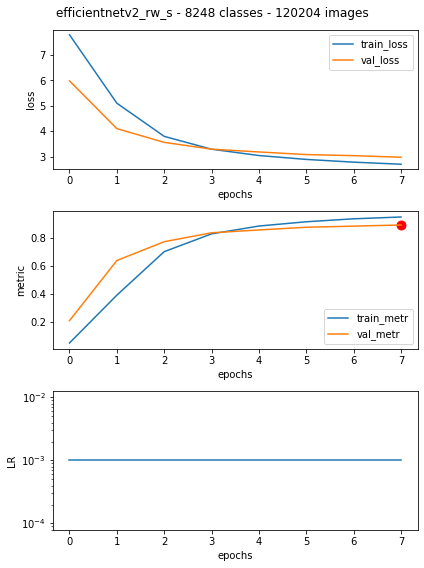

Weights loaded from best epoch 8, metric = 0.89
CPU times: user 1h 3min 28s, sys: 22min 46s, total: 1h 26min 14s
Wall time: 1h 25min 16s


In [52]:
%%time
clear_GPU()
history = train(model, optimizer, loss_fn, 
                epochs=epoch_softmax, 
                data_tr=dl_train, data_val=dl_val, 
                metric=metrics.accuracy_score, best_min_metr=False, scheduler=scheduler, 
                plots=True, set_best_params=True, name=name)

Save.

In [53]:
print('save')
torch.save(model, best_model_ce_path)

save


# Full dataset inference

Just use the meodel on the whole dataset.

First we load it.

In [54]:
df_full = pd.read_pickle(landmark_path)
df_full = df_full.reset_index()

Create DL.

In [55]:
ds_inference = CroppedDataset(df_full, 
                          im_size=(im_width, im_height), stats=cfg_stats, 
                          **face_transform_kwargs)

dl_inference = DataLoader(ds_inference, batch_size=batch_size, 
                     num_workers=num_workers, shuffle=False)

Run batched inference.

In [56]:
def inference_model(trained_model, data_loader):
    embeddings = []
    trained_model.to(device)
    trained_model.eval()
    with torch.no_grad():
        for _, batch in enumerate(tqdm(data_loader)):
            X_batch = batch[0]
            X_batch = X_batch.to(device)
            embed = trained_model(X_batch)
            if mean_flipped:
                embed += trained_model(X_batch.flip(3))
                embed = embed / 2
            embeddings.append(embed.cpu().detach().numpy())

    return np.concatenate(embeddings, axis=0)

embeddings = inference_model(model, dl_inference)

  0%|          | 0/1947 [00:00<?, ?it/s]

Save.

In [57]:
print('saving')
np.save(embed_ce_path, embeddings) # save

saving


Check if everything is of.

In [58]:
embeddings.shape

(124575, 512)

# Cos similarity analisys

First, we'll calculate similarity for people (people! Not photos!), seen by model (val part of dataset).

Remember we used a cleaned dataset for training? Now we need to get our train-val partitions for the whole dataframe.

In [59]:
# save used partition by image_id (not by numerical index)
df_used = df_final[['image_id', 'part']].set_index('image_id')
df_used.to_csv(train_test_split_path)
    
# join full DF and partitions DF on image_id
df_full = pd.read_pickle(landmark_path).drop(columns=['part'])
df_full = df_full.join(df_used).fillna(3)
df_full['part'] = df_full['part'].astype(int)
df_full = df_full.reset_index()

In [60]:
def get_cos_sim_distrib(df_in, embeddings_in):
    tmp_train = df_in[df_in['part'] == 0]
    tmp_val = df_in[df_in['part'] == 1]

    same_person_cos_tmp = []
    diff_person_cos_tmp = []

    # iterate through all persons in val set
    for i, person in enumerate(tqdm(tmp_val['person'].unique())):
        # find the person embeddings index in val set
        idx_val = tmp_val[tmp_val['person'] == person].index
        # find the person embeddings index in train set
        idx_train_true = tmp_train[tmp_train['person'] == person].index
        # find same number of random embeddings of different people in train set
        idx_train_false = tmp_train[tmp_train['person'] != person].sample(len(idx_train_true)).index

        # calculate cos similarity matrix -> flatten
        m_pos = metrics.pairwise.cosine_similarity(embeddings_in[idx_train_true,:],
                                                   embeddings_in[idx_val,:]).flatten()
        m_neg = metrics.pairwise.cosine_similarity(embeddings_in[idx_train_false,:], 
                                                   embeddings_in[idx_val,:]).flatten()

        same_person_cos_tmp.append(m_pos)
        diff_person_cos_tmp.append(m_neg)

    same_person_cos_tmp = np.hstack(same_person_cos_tmp)
    diff_person_cos_tmp = np.hstack(diff_person_cos_tmp)
    
    plt.figure()
    plt.hist(same_person_cos_tmp, bins=100, alpha=0.5, label='same person cos similarity')
    plt.hist(diff_person_cos_tmp, bins=100, alpha=0.5, label='diff persons cos similarity')
    plt.legend()
    plt.title('Validation data (model trained at these faces)')
    plt.show()
    
    return same_person_cos_tmp, diff_person_cos_tmp

  0%|          | 0/8248 [00:00<?, ?it/s]

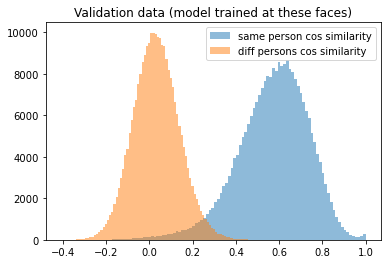

CPU times: user 45.8 s, sys: 79.2 ms, total: 45.9 s
Wall time: 45.7 s


In [61]:
%%time
same_person_cos_train, diff_person_cos_train = get_cos_sim_distrib(df_full, embeddings);

Yes! The distributions look really different.

Different images cos_sim distribution looks "normal" around 0.

Same images distribution is greatly shifted towards 1.

But two distributions intersect :(

# Custom metric TPR@FPR

Lets implement custom metrics based on test sample - images not used in training. Model hasn't seen these people at all.

Here is a list of seen people.

In [62]:
seen_persons = df_full[df_full['part'] < 3]['person'].unique()

Get dataframe of unseen people with large enough photos.

In [63]:
df_others = df_full[(df_full['part'] == 3) & (~df_full['person'].isin(seen_persons))]
df_others = df_others[(df_others['w'] >= min_im_width) & (df_others['h'] >= min_im_height)]
print('num images:', len(df_others), 'num people', len(df_others['person'].unique()))

num images: 4371 num people 1779


Lets look at images count distribution.

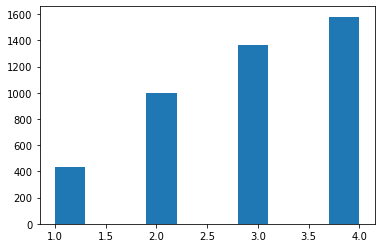

In [64]:
df_others['count'] = df_others.groupby('person')['image_id'].transform('count')
plt.hist(df_others['count']);

Now we set some limit for image counts. If there are many images, that person goes to 'query' part. Else - to 'distractor' part.

In [65]:
# count_cut = 5
count_cut = max(2, df_others['count'].quantile(0.2))
print('count_cut', count_cut)
count_cut_max = 8 # min(8, df_others['count'].quantile(0.2))

df_others['part'] = 0
df_others['part'] = 1
# df_others.loc[df_others['count'] >= count_cut, 'part'] = 1
# df_others.loc[df_others['count'] >= count_cut_max, 'part'] = 2
df_others['part'].value_counts()

count_cut 2


1    4371
Name: part, dtype: int64

Here is the idea behing TPR@FPR.

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos.
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset.
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
fix FPR (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
5. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our threshold similarity.
6. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.


This metric can also be expressed as TPR@FPR=0.01. FPR can vary.

In [66]:
def get_tpr_at_fpr(df_in, embeddings_in, fprs=[0.01], show=True):
    
    # get query DF and distractor idx
    query = df_in[df_in['part'] == 1]
    idx_distractor = df_in[df_in['part'] == 0].index

    same_person_cos_tmp = []
    diff_person_cos_tmp = []

    # iterate through all persons in val set
    for i, person in enumerate(query['person'].unique()):
                
        # find the persons index and all other people idx
        idx_q_true = query[query['person'] == person].index
        idx_q_false = query[query['person'] != person].index

        # calculate cos similarity for query -> query
        
        # positive - only upper triangle!
        if len(idx_q_true) >= 2:
            m_pos = metrics.pairwise.cosine_similarity(embeddings_in[idx_q_true,:],
                                                       embeddings_in[idx_q_true,:])
            m_pos = m_pos[np.triu_indices(len(m_pos), k = 1)]

            # save results to lists
            same_person_cos_tmp.append(m_pos)
        
        # negatives - full matrix -> flatten
        m_neg = metrics.pairwise.cosine_similarity(embeddings_in[idx_q_true,:], 
                                                   embeddings_in[idx_q_false,:]).flatten()
        diff_person_cos_tmp.append(m_neg)

        # calculate cos similarity for query -> distractor
        if len(idx_distractor) > 0:
            m_neg = metrics.pairwise.cosine_similarity(embeddings_in[idx_q_true,:], 
                                                       embeddings_in[idx_distractor,:]).flatten()

            diff_person_cos_tmp.append(m_neg)

    # lists -> numpy arr
    same_person_cos_tmp = np.hstack(same_person_cos_tmp)
    diff_person_cos_tmp = np.hstack(diff_person_cos_tmp)
    print(
        len(same_person_cos_tmp),
        len(diff_person_cos_tmp)
    )

    tprs = []
    thresholds = []
    diff_person_cos_tmp.sort()
    for fpr in fprs:
        # find threshold
        N = int(fpr * len(diff_person_cos_tmp))
        threshold = diff_person_cos_tmp[::-1][N]
        thresholds.append(threshold)

        # find TPR
        tpr = (same_person_cos_tmp >= threshold).mean()
        tprs.append(tpr)

        if show:
            print(f'TPR@FPR={fpr}: {tpr:.3}, threshold {threshold:.3}')
            
    return fprs, tprs, thresholds, same_person_cos_tmp, diff_person_cos_tmp

4231 19092808
TPR@FPR=0.1: 0.918, threshold 0.188
TPR@FPR=0.03: 0.874, threshold 0.263
TPR@FPR=0.01: 0.827, threshold 0.324
TPR@FPR=0.003: 0.768, threshold 0.387
TPR@FPR=0.001: 0.698, threshold 0.439


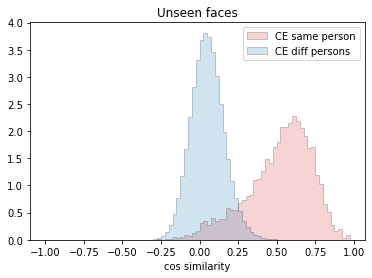

In [67]:
fprs_list = [0.1, 0.03, 0.01, 0.003, 0.001]

fprs, tprs, thresholds, same_person_cos, diff_person_cos = get_tpr_at_fpr(
    df_others, embeddings, fprs=fprs_list)

plt.figure()
kw_density_hist = dict(
    alpha=0.2, bins=np.arange(-1,1,0.025), edgecolor='black', 
    histtype= "stepfilled", density=True)
plt.hist(same_person_cos, **kw_density_hist, hatch='', facecolor='tab:red', label='CE same person')
plt.hist(diff_person_cos, **kw_density_hist, hatch='', facecolor='tab:blue', label='CE diff persons')
plt.xlabel('cos similarity')
plt.title('Unseen faces')
plt.legend();
plt.show()

# Embeddings norm

During training embeddings are centered around 0 and batch-normalized (not individually!). So up until now we didn't use embedding norms, we used only angles.

Lets calculate norms, sort them and look at the "longest" and "shortest" embeddings.

We'll use only 'test' part of dataset.

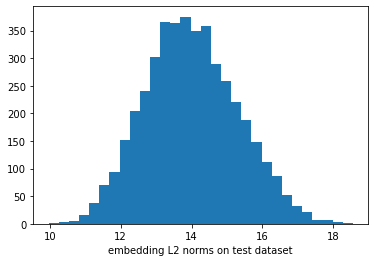

In [68]:
test_index = df_full[df_full['part'] > 1].index
e = pd.Series(np.linalg.norm(embeddings, axis=1))[test_index]
plt.hist(e, bins=30);
plt.xlabel('embedding L2 norms on test dataset');

Assistant function.

In [69]:
def show_some_pics(df_in, idx_list, rows=4, cols=4, name=''):
    
    fig = plt.figure(figsize=(8,10))
    
    pics = df_in.loc[idx_list]['file'].to_list()
    lm_coordinates = df_in.loc[idx_list]['lm_abs'].to_list()
    
    for i in range(rows):
        for j in range(cols):
            k = i*rows+j
            if k > len(pics):
                break
            fname = pics[k]
            plt.subplot(rows,cols,k+1)
            image = cv2.imread(fname)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            c = lm_coordinates[k]
            image = ds_inference.align(image, c)
            
            plt.imshow(image)
            plt.axis('off')
        if k > len(pics):
                break
    
    fig.patch.set_facecolor('xkcd:white')
    if len(name) > 0:
        plt.suptitle(name)
    fig.tight_layout()
    plt.show()

Shortest embeddings:

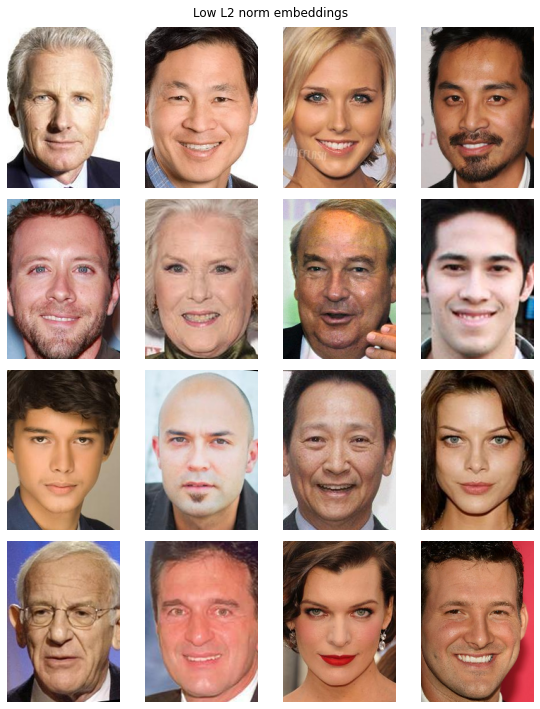

In [70]:
idx = e.sort_values().index
show_some_pics(df_full, idx, name='Low L2 norm embeddings')

These faces seem to look OK.

Now lets look at highest embedding norms.

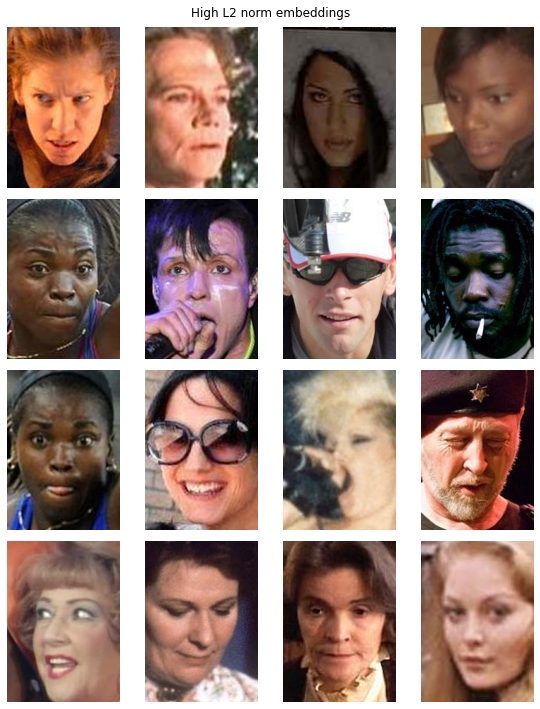

In [71]:
idx = e.sort_values(ascending=False).index
show_some_pics(df_full, idx, name='High L2 norm embeddings')

These are OK too, although they have lower quality and/or strange face expressions.

In theory unusually high embeddings could mean some trash photos, that maybe don't even have faces in them. But in practice our face detection network just filters out these photos.

# Advanced - Arcface loss

First we create the loss module (trainable). Here is the "default" implementation from original paper without any tricks.

Also we calculate predictions as a simple argmax WITHOUT margin. This will be used ONLY to measure accuracy during training.

Original paper: https://arxiv.org/pdf/1801.07698.pdf

In [72]:
class ArcFaceLoss(nn.Module):
    
    """
    Loss as nn.module that works like CrossEntropyLoss
    """
    
    def __init__(self, emb_size, output_classes, m=0.5, s=64, kwargs_ce_loss={}):
        super().__init__()
        
        # create "weights" - matrix of centroids for training classes in embedding space
        self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
        # random init
        nn.init.xavier_normal_(self.W)
        
        self.output_classes = output_classes
        self.s = s
        
        # need cos ande sin to calc cos(theta+m)
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        
        # arcface loss is still cross-entroy loss...
        self.ce_loss = nn.CrossEntropyLoss(**kwargs_ce_loss)
        
    def forward(self, embedding, target):
        # normalize embeddings and centroids
        embedding = F.normalize(embedding, dim=1)
        W_norm = F.normalize(self.W, dim=0)
        
        # calc cos and sin theta
        cos_th = embedding @ W_norm
        cos_th = cos_th.clip(-1, 1)
        sin_th = torch.sqrt(1 - torch.square(cos_th))
        
        # for 'accuracy' calculation
        preds = cos_th.argmax(dim=1)
        
        # calc cos(theta+m)
        if self.m != 0:
            cos_th_m = cos_th * self.cos_m - sin_th * self.sin_m

            # encode target classes for the batch
            onehot = F.one_hot(target, num_classes=self.output_classes)

            # use cos(theta+m) for target class and cos(theta) for other classes
            cos_th = torch.where(onehot > 0, cos_th_m, cos_th)
        
        # scale coeff
        cos_th *= self.s
        
        # use CELoss on our "logits"
        return self.ce_loss(cos_th, target), preds

Important: we have already trained our model to get some adequate (maybe not best, but still good) embeddings. We will use arcface loss to train that model further.

In [73]:
model = torch.load(best_model_ce_path, map_location=torch.device(device))

But first we need to train only arcface loss to get some adequate class centroids.

There is a paper about automatic scaling of arcface: https://arxiv.org/pdf/1905.00292.pdf

We will use the equation for scale factor from it.

In [74]:
scale = int(2**0.5*math.log(num_classes-1))
scale

12

To train faster we'll get the W matrix for arcface loss from the CE head, used to train the classifier.

Get centroids from CE training.

In [75]:
w_matrix = loss_fn.fc.weight.data.T.cpu().detach()
w_matrix

tensor([[-0.0541,  0.0156,  0.1513,  ...,  0.0863, -0.0898,  0.0418],
        [-0.0867,  0.1487,  0.0240,  ...,  0.0834,  0.1226, -0.0515],
        [-0.0864, -0.0308, -0.0505,  ...,  0.0275, -0.0194,  0.1294],
        ...,
        [ 0.0623, -0.0096, -0.0297,  ..., -0.0875, -0.0008, -0.0489],
        [-0.0422, -0.1003,  0.0099,  ..., -0.0837,  0.0683, -0.0667],
        [-0.1503, -0.0851,  0.0004,  ...,  0.1051, -0.0050, -0.0438]])

Use centroids to initialise arcface W matrix.

In [76]:
kwargs_ce_loss_arc = dict(
    label_smoothing=label_smoothing_arcface,
    weight=class_balance
)

loss_arc = ArcFaceLoss(emb_size=embed_size,
                       output_classes=num_classes,
                       s=scale,
                       kwargs_ce_loss=kwargs_ce_loss_arc
                      )

# get centroids from CE training
if w_matrix.shape[0] > 0:
    loss_arc.W.data = w_matrix

loss_arc.to(device);

Train both model and loss.

In [77]:
optimizer_arc = opt_alg([
    {'params':model.parameters()}, 
    {'params':loss_arc.parameters()}
], lr=2e-3, weight_decay=weight_decay)


scheduler = None

if sched_type == 'exp':
    scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer_arc, 
        gamma=(lr_decay_max_epoch_arc)**(1/epoch_arcface))
    
elif sched_type == 'plateau':
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_arc,
        mode='max',
        factor=0.1,
        patience=1,
        threshold=1e-3
    )

name = cfg['architecture'] + ' - ArcFace - ' + str(len(df_final['person'].unique())) + ' classes - ' + str(len(df_final)) + ' images'

Train.

tr_loss: 4.19  tr_metr: 0.98   val_loss: 4.46  val_metr: 0.93


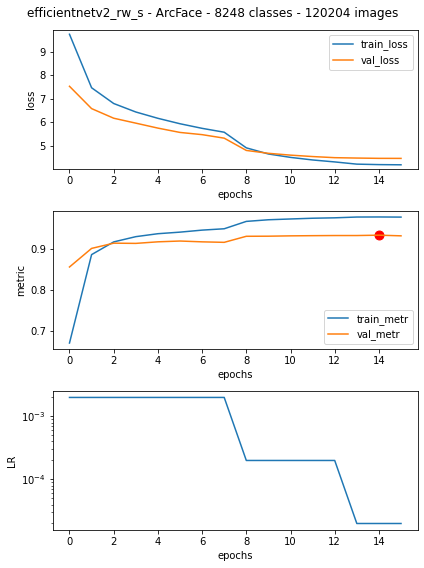

Weights loaded from best epoch 15, metric = 0.93
CPU times: user 2h 8min 13s, sys: 45min 54s, total: 2h 54min 8s
Wall time: 2h 52min 9s


In [78]:
%%time
clear_GPU()
history = train(model, optimizer_arc, loss_arc, 
                epochs=epoch_arcface, 
                data_tr=dl_train, data_val=dl_val, 
                metric=metrics.accuracy_score, best_min_metr=False, scheduler=scheduler, 
                plots=True, set_best_params=True, name=name)

The model easily overfits, so we use the early stopping.

In [79]:
print('save')
torch.save(model, best_model_arc_path)

save


Inference.

In [80]:
fname = table_path + '/embed_arc.npy'
print('calculating embeddings')
embeddings_arc = inference_model(model, dl_inference)
print('saving')
np.save(fname, embeddings_arc) # save
embeddings_arc.shape

calculating embeddings


  0%|          | 0/1947 [00:00<?, ?it/s]

saving


(124575, 512)

# Cos similarity analisys for arcface

  0%|          | 0/8248 [00:00<?, ?it/s]

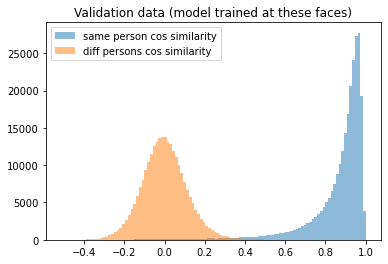

CPU times: user 47 s, sys: 88.1 ms, total: 47.1 s
Wall time: 46.9 s


In [81]:
%%time
same_person_cos_arc_train, diff_person_cos_arc_train = get_cos_sim_distrib(
    df_full, embeddings_arc);

Well, the result seems to be better than for simple CE loss.

Lets plot them together.

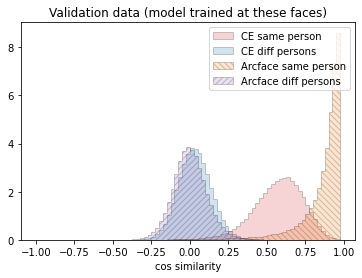

In [82]:
plt.hist(same_person_cos_train, **kw_density_hist, hatch='', facecolor='tab:red', label='CE same person')
plt.hist(diff_person_cos_train, **kw_density_hist, hatch='', facecolor='tab:blue', label='CE diff persons')
plt.hist(same_person_cos_arc_train, **kw_density_hist, hatch='\\\\\\\\', facecolor='tab:orange', label='Arcface same person')
plt.hist(diff_person_cos_arc_train, **kw_density_hist, hatch='////', facecolor='tab:purple', label='Arcface diff persons')
plt.xlabel('cos similarity')
plt.title('Validation data (model trained at these faces)')
plt.legend();

The cos similarity distribution for arcface looks awesome. But these are the seen faces. What about new faces?

# Custom metric TPR@FPR for arcface

4231 19092808
TPR@FPR=0.1: 0.933, threshold 0.15
TPR@FPR=0.03: 0.903, threshold 0.261
TPR@FPR=0.01: 0.859, threshold 0.369
TPR@FPR=0.003: 0.784, threshold 0.476
TPR@FPR=0.001: 0.69, threshold 0.563


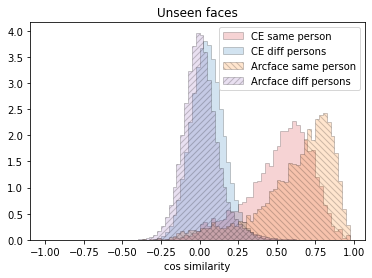

In [83]:
fprs, tprs, thresholds, same_person_cos_arc, diff_person_cos_arc = get_tpr_at_fpr(
    df_others, embeddings_arc, fprs=fprs_list)

plt.figure()
plt.hist(same_person_cos, **kw_density_hist, hatch='', facecolor='tab:red', label='CE same person')
plt.hist(diff_person_cos, **kw_density_hist, hatch='', facecolor='tab:blue', label='CE diff persons')
plt.hist(same_person_cos_arc, **kw_density_hist, hatch='\\\\\\\\', facecolor='tab:orange', label='Arcface same person')
plt.hist(diff_person_cos_arc, **kw_density_hist, hatch='////', facecolor='tab:purple', label='Arcface diff persons')
plt.xlabel('cos similarity')
plt.title('Unseen faces')
plt.legend();
plt.show()

It looks worse, but still has a good metric.

Lets look at embeddings L2 norm distribution.

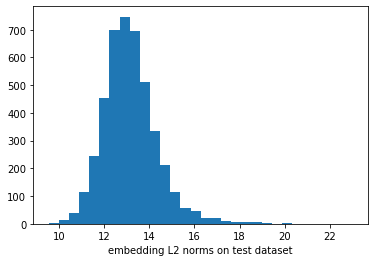

In [84]:
test_index = df_full[df_full['part'] > 1].index
e = pd.Series(np.linalg.norm(embeddings_arc, axis=1))[test_index]
plt.hist(e, bins=30);
plt.xlabel('embedding L2 norms on test dataset');

Low embedding L2 norm values:

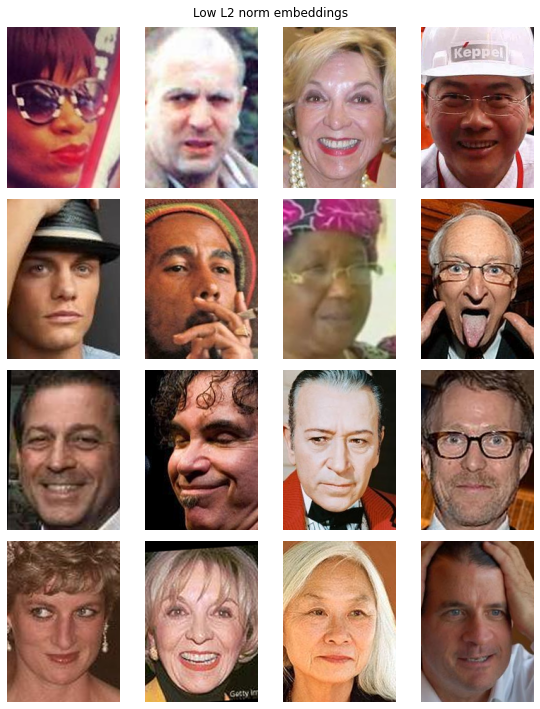

In [85]:
idx = e.sort_values().index
show_some_pics(df_full, idx, name='Low L2 norm embeddings')

High embedding L2 norm values:

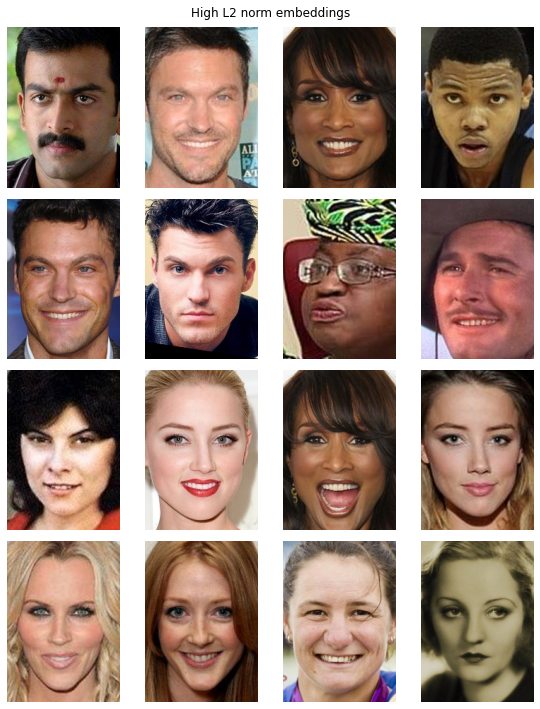

In [86]:
idx = e.sort_values(ascending=False).index
show_some_pics(df_full, idx, name='High L2 norm embeddings')

These photos have OK quality.

# Result

Now we have:
- embeddings list file containing embeddings for all found faces in the dataset
- saved model for getting embedding from aligned face

Next step - implement complete inference using all trained NNetworks.